---

# Topic Modeling (Prepare)

On Monday we talked about summarizing your documents using just token counts. Today, we're going to learn about a much more sophisticated approach - learning 'topics' from documents. Topics are a latent structure. They are not directly observable in the data, but we know they're there by reading them.

> **latent**: existing but not yet developed or manifest; hidden or concealed.

## Use Cases
Primary use case: what the hell are your documents about? Who might want to know that in industry - 
* Identifying common themes in customer reviews
* Discovering the needle in a haystack 
* Monitoring communications (Email - State Department) 

## Learning Objectives
*At the end of the lesson you should be able to:*
* Part 0: Warm-Up
* Part 1: Describe how an LDA Model works
* Part 2: Estimate a LDA Model with Gensim
* Part 3: Interpret LDA results & Select the appropriate number of topics

# Part 0: Warm-Up
How do we do a grid search? 

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
data = fetch_20newsgroups()

In [4]:
data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [5]:
np.unique(data.target)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [6]:
# create X and Y from data
X = data.data
Y = data.target

In [10]:
X[0]

"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n"

### GridSearch on Just Classifier
* Fit the vectorizer and prepare BEFORE it goes into the gridsearch

In [11]:
# create tfidf instant
tfidf = TfidfVectorizer()

# transform data
X_dtm = tfidf.fit_transform(X)

# create parameter dict
param = {
    "n_estimators": [10, 100], 
    "max_depth": [None, 10]
}

# create model instance 
rfc = RandomForestClassifier()

# instantiate a grid search object
gs = GridSearchCV(rfc, 
                  param, 
                  cv = 3, 
                  n_jobs=-2, 
                  verbose=1)

# optimize model parameters
gs.fit(X_dtm, Y)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-2,
             param_grid={'max_depth': [None, 10], 'n_estimators': [10, 100]},
             verbose=1)

In [9]:
# create and tranform a sample text 
sample_text = ["I love baseball"]

# transform sample text outside of model
sample_vect = tfidf.transform(sample_text)

# use the model to classify the sample tet 
best_model = gs.best_estimator_

# get prediction of sample text 
y_hat = best_model.predict(sample_vect)

In [10]:
# get prediction topic name
y_hat, data.target_names[y_hat[0]]

(array([9]), 'rec.sport.baseball')

### GridSearch with BOTH the Vectoizer & Classifier

In [11]:
from sklearn.pipeline import Pipeline

# create tfidf instance
v2 = TfidfVectorizer()

# create model instance 
clf = RandomForestClassifier()

# Create a pipline instance using tfidf and your model 
pipe = Pipeline([
    ('vect', v2),
    ('clf', clf)
])

# create parameter dict
p2 = {
    'vect__max_features':[1000,5000],
    'clf__n_estimators':[10,20],
    'clf__max_depth': [None, 7]
}

# instantiate a grid search object
gs2 = GridSearchCV(pipe, 
                   p2, 
                   cv=3,
                   n_jobs=-2, 
                   verbose=1)

# optimize model parameters
gs2.fit(X, Y)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                       ('clf', RandomForestClassifier())]),
             n_jobs=-2,
             param_grid={'clf__max_depth': [None, 7],
                         'clf__n_estimators': [10, 20],
                         'vect__max_features': [1000, 5000]},
             verbose=1)

In [12]:
# pass a raw text sample into the optimized model in order to classify it
sample_text = ["I love baseball"]
y_hat = gs2.predict(sample_text)

In [13]:
y_hat

array([9])

Advantages to using GS with the Pipe:
* Allows us to make predictions on raw text increasing reproducibility. :)
* Allows us to tune the parameters of the vectorizer along side the classifier. :D 

----
# Part 1: Describe how an LDA Model works

[Your Guide to Latent Dirichlet Allocation](https://medium.com/@lettier/how-does-lda-work-ill-explain-using-emoji-108abf40fa7d) Article that provides an explaination of LDA by using the same interactive tool that we use in class. 

[LDA Topic Modeling](https://lettier.com/projects/lda-topic-modeling/) Interactive tool that allows us to play with parameter values and see how that affects the output of applying LDA to a corpus. 

[Topic Modeling with Gensim](https://radimrehurek.com/gensim/) This is the documentation of the NLP library Gensim. Gensim has some pretty cool NLP specific ML modelings (such as LDA and doc2vec) that you can use. Definately a resource worth knowning!

------
### About the video on LDA

This video does a great job of using plently of visual aids and examples to accompany an **explaination of the underlying mathematics of LDA**. In other words, if you are interested in learning about the math of how LDA works, then definately check out this video. 

**Note:** Mathematical knowledge of LDA is considered optional. You will **not** be tested on it. 

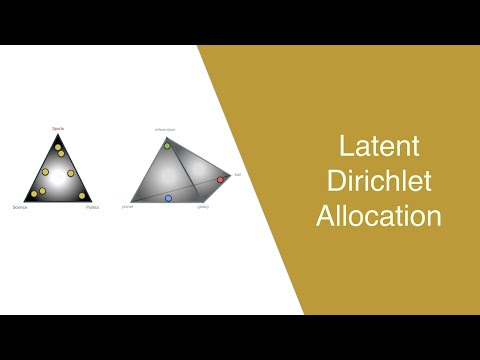

In [14]:
from IPython.display import YouTubeVideo
# Check out this 4 minute video for a deeper discussion on LSA
YouTubeVideo('T05t-SqKArY')

-----

In [15]:
# an alternative approach to downloading the spaCy pre-trained model 

# Download spacy model
import spacy.cli
# Note: please download and use the small version of spacy pre-trained model on the Sprint Challenge 
spacy.cli.download("en_core_web_sm")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [16]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# our new NLP python package 
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy

# pipenv install pyLDAvis
# OR pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
df = pd.DataFrame({
    'content': data['data'],
    'target': data['target'],
    'target_names': [data['target_names'][i] for i in data['target']]
});

/Users/jenniferquigley/.local/share/virtualenvs/DS-Unit-4-Sprint-1-NLP-gQtURTt4/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
# take a look at an article
# we can see that we need to do some data cleaning - let's create a function for that 
df.content.iloc[0]

/Users/jenniferquigley/.local/share/virtualenvs/DS-Unit-4-Sprint-1-NLP-gQtURTt4/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n"

In [19]:
# can visit (https://regex101.com/) for a regex python editor (has cheat sheets!)
def clean_data(doc):
        
    # Remove Emails
    doc = re.sub("From: \S+@\S+", "", doc)
    
    # Remove new line characters
    doc = re.sub("\n+", " ", doc)
    
    # Remove non-alphanumeric characters
    doc = re.sub("[^0-9 a-zA-Z]+", "", doc)
    
    doc = re.sub(" +", " ", doc)
    
    # case normalization 
    doc = doc.lower()
    
    # Remove leading and trailing whitespace
    return doc.strip()

/Users/jenniferquigley/.local/share/virtualenvs/DS-Unit-4-Sprint-1-NLP-gQtURTt4/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:5: DeprecationWarning: invalid escape sequence \S
<>:5: DeprecationWarning: invalid escape sequence \S
<ipython-input-19-3fd3a149aa5a>:5: DeprecationWarning: invalid escape sequence \S
  doc = re.sub("From: \S+@\S+", "", doc)


In [20]:
# this line of code iteraters throught the N number of docs 
# save clean data to a new feature for comparison with raw text 
df["clean_text"] = df.content.apply(lambda doc: clean_data(doc))

/Users/jenniferquigley/.local/share/virtualenvs/DS-Unit-4-Sprint-1-NLP-gQtURTt4/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
# manually inspect to see that you got your intended results 
df.clean_text.iloc[0]

/Users/jenniferquigley/.local/share/virtualenvs/DS-Unit-4-Sprint-1-NLP-gQtURTt4/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'wheres my thing subject what car is this nntppostinghost rac3wamumdedu organization university of maryland college park lines 15 i was wondering if anyone out there could enlighten me on this car i saw the other day it was a 2door sports car looked to be from the late 60s early 70s it was called a bricklin the doors were really small in addition the front bumper was separate from the rest of the body this is all i know if anyone can tellme a model name engine specs years of production where this car is made history or whatever info you have on this funky looking car please email thanks il brought to you by your neighborhood lerxst'

In [22]:
# (optional) this is how you download a python package inside of a notebook
#!pip install pandarallel 

/Users/jenniferquigley/.local/share/virtualenvs/DS-Unit-4-Sprint-1-NLP-gQtURTt4/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
from pandarallel import pandarallel

# find out how many processors your machine has N
# then set nb_workers = N - 1
n_cpus = 11
pandarallel.initialize(progress_bar=True, nb_workers=n_cpus)

INFO: Pandarallel will run on 11 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


/Users/jenniferquigley/.local/share/virtualenvs/DS-Unit-4-Sprint-1-NLP-gQtURTt4/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
# when working locally, feel free to use the large version of the pre-trained model
nlp = spacy.load("en_core_web_lg")

/Users/jenniferquigley/.local/share/virtualenvs/DS-Unit-4-Sprint-1-NLP-gQtURTt4/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
%%time
# create our tokens in the form of lemmas 
# by using df.parallel_apply() we are using the parallel version of the apply method 
# should result in a shorter runtime 
df['lemmas'] = df['clean_text'].parallel_apply(lambda text: [token.lemma_ for token in nlp(text) if (token.is_stop != True) and (token.is_punct != True)])

/Users/jenniferquigley/.local/share/virtualenvs/DS-Unit-4-Sprint-1-NLP-gQtURTt4/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df.head()

### The two main inputs to the LDA topic model are the dictionary (id2word) and the corpus.

### Store the tokens/lemmas in a couple of formats that the LDA model is expecting. 

In [ ]:
# we have over 11K docs 
# In class I took a subsample of 2000 docs so that the runtime would be much shorter 
# Debugging Pro tip! Take a subsample of data whenever 1) you have a big data set and 2) you're still testing your code and fixing bugs 
df.shape

In [ ]:
keep_N_docs = 2000
# Create Dictionary
id2word = corpora.Dictionary(df["lemmas"].iloc[:keep_N_docs])

# Term Document Frequency for each doc -> doc-term matrix 
corpus = [id2word.doc2bow(list_of_token) for list_of_token in df["lemmas"].iloc[:keep_N_docs]]

In [ ]:
# stores (token id, token count) for each doc in the corpus
doc_id = 13
corpus[doc_id]

counter = 0
# Human readable format of corpus (term-frequency)
for token_id, token_count in corpus[doc_id]:
    print (id2word[token_id], token_id)
    
    if counter == 10:
        break  
    counter +=1

# Part 2: Estimate a LDA Model with Gensim

 ### Train an LDA model

In [ ]:
### This cell runs the single-processor version of the model (slower)
# %%time

# # USE THIS VERSION OF THE LDA MODEL DURING THE SPRINT CHALLENGE
# lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
#                                            id2word=id2word,
#                                            num_topics=20, 
#                                            chunksize=100,
#                                            passes=10,
#                                            per_word_topics=True)
lda_model.save('lda_model.model')
# # https://radimrehurek.com/gensim/models/ldamodel.html

In [ ]:
%%time
### This cell runs the multi-processor version of the model (faster)
lda_multicore = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2word,
                                                        num_topics=20, 
                                                        chunksize=100,
                                                        passes=3,
                                                        per_word_topics=True,
                                                        workers=11)

In [ ]:
# it's a good idea to save models to memory that take a long time to train 

lda_multicore.save('lda_multicore.model')

In [ ]:
# this is how you load in trained models 
# see docs for more details: https://radimrehurek.com/gensim/models/ldamulticore.html

from gensim import models
lda_multicore =  models.LdaModel.load('lda_multicore.model')

# Part 3: Interpret LDA results & Select the appropriate number of topics

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_multicore, corpus, id2word)
vis

### What is topic coherence?
Topic Coherence measures score a single topic by **measuring the degree of semantic similarity between high scoring words in the topic**. These measurements help distinguish between topics that are semantically interpretable topics and topics that are artifacts of statistical inference.


A set of statements or facts is said to be coherent, if they support each other. Thus, a coherent fact set can be interpreted in a context that covers all or most of the facts. An example of a coherent fact set is **“the game is a team sport”**, **“the game is played with a ball”**, **“the game demands great physical efforts”**


In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2word,
                                                        num_topics=num_topics, 
                                                        chunksize=100,
                                                        passes=10,
                                                        per_word_topics=True,
                                                        workers=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
%%time
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=df['lemmas'].iloc[:keep_N_docs], start=2, limit=22, step=4)

In [ ]:
# use these values for the plot if compute_coherence_values takes too long to run 
#coherence_values = [0.5054, 0.5332, 0.5452, 0.564, 0.5678, 0.5518, 0.519]

In [ ]:
limit=22; start=2; step=4;
x = range(start, limit, step)
plt.figure(figsize=(10,6))
plt.plot(x, coherence_values)
plt.grid()
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [ ]:
# Select the model and print the topics
optimal_model = model_list[1]
#optimal_model =  models.LdaModel.load('optimal_model.model')
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))